In [16]:
import jax
import jax.numpy as jnp
import chex

from typing import NamedTuple

from experior.utils import PRNGSequence, moving_average, QNetwork

jax.config.update("jax_debug_nans", True)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
EPISODES = 3000
env_config = {
  "horizon": 15,
  "num_envs": 15,
}

expert_config = {
  "mc_samples": -1,
  "beta": 1.0,
  "n_trajectories": 1000,
}

q_network_config = {
  "n_hidden": 32,
  "n_features": 8,
}

dqn_config = {
  "buffer_size": 10000,
  "target_network_frequency": 10,
  "batch_size": 64,
  "start_epsilon": 1.0,
  "end_epsilon": 0.05,
  "exploration_fraction": 0.5,
  "learning_starts": 1,
  "train_frequency": 5,
  "steps": env_config["horizon"] * EPISODES,
  "discount_factor": 1.,
  "learning_rate": 2.5e-4,
}

lmc_dqn_config = {
  "buffer_size": 10000,
  "target_network_frequency": 10,
  "batch_size": 64, # TODO Batch Size is less before start - fix it
  "train_frequency": 1,
  "steps": env_config["horizon"] * EPISODES,
  "discount_factor": 1.,
  "learning_rate": 2.5e-4,
  "temperature": 1e-3, # TODO test with multiple hyperparams + maybe multiple updates per epoch + evaluation vs training + episode v.s. horizon
}

max_ent_dqn_config = {
  "buffer_size": 10000,
  "target_network_frequency": 10,
  "batch_size": 64,
  "train_frequency": 1,
  "steps": env_config["horizon"] * EPISODES,
  "discount_factor": 1.,
  "learning_rate": 2.5e-4,
  "temperature": 1e-3,
  "max_ent_lambda": 100,
  "max_ent_epsilon": 1e-3,
  "max_ent_learning_rate": 5e-2,
  "max_ent_prior_n_samples": 500,
  "max_ent_updates_per_step": 100,
  "max_ent_updates_frequency": 10,
  "expert_beta": 10.0,
  "slgd_updates_per_step": 1
}

## Environment

In [34]:
from experior.envs import DeepSea
goal_col_dist = jax.tree_util.Partial(
    lambda key, size: size - 1 #jax.random.randint(key, shape=(), minval=size // 2, maxval=size)
)
env = DeepSea(size=env_config["horizon"], goal_column_dist=goal_col_dist)

## Generate Expert Trajectories

In [35]:
from experior.experts.default_discrete_action import generate_optimal_trajectories

In [36]:
jax.config.update("jax_disable_jit", False)
rng = PRNGSequence(42)
expert_trajectories = generate_optimal_trajectories(next(rng),
                                                    env,
                                                    expert_config["n_trajectories"],
                                                    env_config["horizon"])

In [37]:
expert_trajectories.action

Array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0]], dtype=int32)

## Deep Q-Network

In [7]:
from experior.agents import make_dqn_train
q_network = QNetwork(n_actions=env.num_actions, **q_network_config)
dqn_train = make_dqn_train(env=env, q_network=q_network, num_envs=env_config["num_envs"], **dqn_config)

In [8]:
jax.config.update("jax_disable_jit", False)
dqn_train = jax.jit(dqn_train)
runner_state, dqn_output = dqn_train(jax.random.PRNGKey(4536))

/h/vdblm/.jax_env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


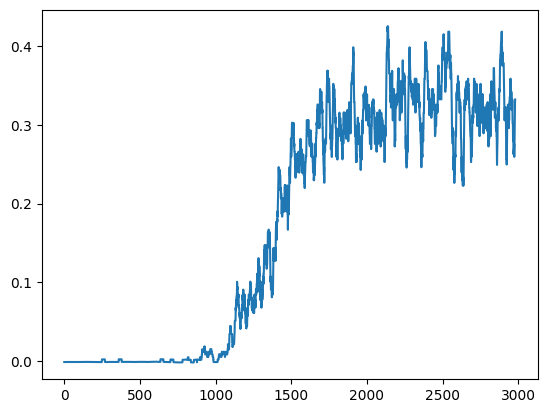

In [9]:
import matplotlib.pyplot as plt
per_episode_reward = dqn_output['reward'].mean(axis=-1).reshape(-1, env_config["horizon"]).sum(axis=-1)
plt.plot(moving_average(per_episode_reward, 20))

## Adam LMCDQN

In [30]:
from experior.agents import make_lmc_dqn_train
q_network = QNetwork(n_actions=env.num_actions, **q_network_config)
lmc_dqn_train = make_lmc_dqn_train(env=env, q_network=q_network, num_envs=env_config["num_envs"], **lmc_dqn_config)

In [31]:
jax.config.update("jax_disable_jit", False)
lmc_dqn_train = jax.jit(lmc_dqn_train)
runner_state, lmc_dqn_output = lmc_dqn_train(jax.random.PRNGKey(4536))

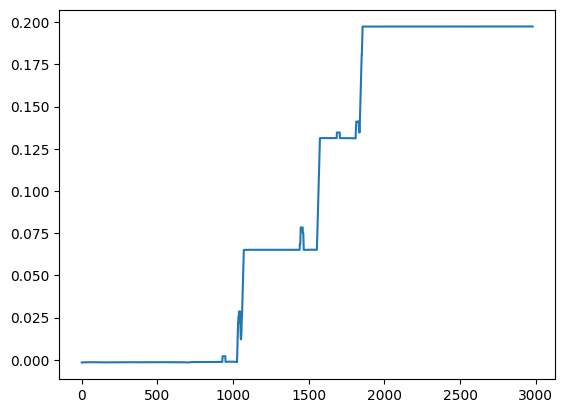

In [32]:
import matplotlib.pyplot as plt
per_episode_reward = lmc_dqn_output['reward'].mean(axis=-1).reshape(-1, env_config["horizon"]).sum(axis=-1)
plt.plot(moving_average(per_episode_reward, 20))


## Max-Entropy LMC DQN

In [26]:
from experior.agents import make_max_ent_dqn_train
q_network = QNetwork(n_actions=env.num_actions, **q_network_config)
max_ent_dqn_train = make_max_ent_dqn_train(env=env, q_network=q_network, num_envs=env_config["num_envs"], **max_ent_dqn_config)

In [27]:
jax.config.update("jax_disable_jit", False)
max_ent_dqn_train = jax.jit(max_ent_dqn_train)
runner_state, max_ent_output = max_ent_dqn_train(jax.random.PRNGKey(4536), expert_trajectories)

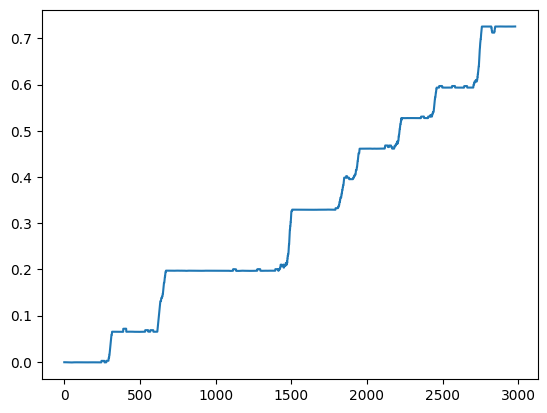

In [28]:
import matplotlib.pyplot as plt
per_episode_reward = max_ent_output['reward'].mean(axis=-1).reshape(-1, env_config["horizon"]).sum(axis=-1)
plt.plot(moving_average(per_episode_reward, 20))

## All Final Results

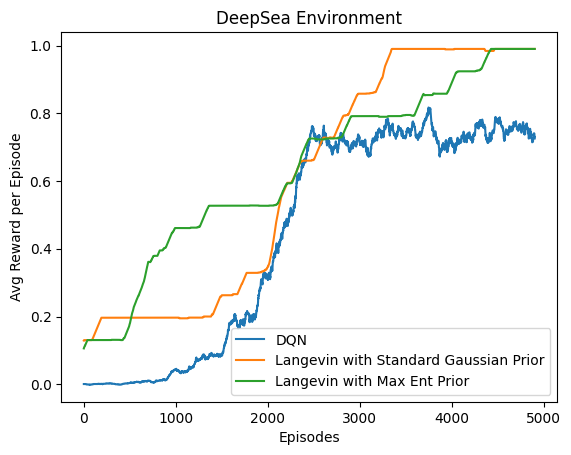

In [35]:
window_size = 100
plt.plot(moving_average(dqn_output['reward'].mean(axis=-1).reshape(-1, env_config["horizon"]).sum(axis=-1), window_size), label="DQN")
plt.plot(moving_average(lmc_dqn_output['reward'].mean(axis=-1).reshape(-1, env_config["horizon"]).sum(axis=-1), window_size), label="Langevin with Standard Gaussian Prior")
plt.plot(moving_average(max_ent_output['reward'].mean(axis=-1).reshape(-1, env_config["horizon"]).sum(axis=-1), window_size), label="Langevin with Max Ent Prior")

plt.xlabel("Episodes")
plt.ylabel("Avg Reward per Episode")
plt.title("DeepSea Environment")
plt.legend()

plt.show()